In [ ]:
import pandas as pd
import numpy as np

# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',300)

# FOR REMOVING SPECIAL CHARACTERS, LINKS, AND EXPANDING WORDS,TAGS
import re
import unicodedata
from bs4 import BeautifulSoup

# FOR STEMMING AND REMOVING STOP WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer   
from nltk.corpus import wordnet
from nltk import pos_tag

# FOR BUILDING THE EMBEDDING MATRIX AND GENERATING THE SEQUENCES
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [ ]:
!wget https://github.com/Semeval2019Task9/Subtask-A/archive/master.zip

import zipfile
zip_ref = zipfile.ZipFile('/content/master.zip')
zip_ref.extractall('/content/')
zip_ref.close()

train_data=pd.read_csv("/content/Subtask-A-master/V1.4_Training.csv",header=None)
test_data=pd.read_csv("/content/Subtask-A-master/SubtaskA_Trial_Test_Labeled.csv",encoding='latin-1')
valid_data=pd.read_csv("/content/Subtask-A-master/SubtaskA_EvaluationData_labeled.csv",encoding='latin-1',header=None)

In [ ]:
#####################################################################################
##########################        CLEANING THE DATA        ##########################
#####################################################################################

# BUILD CACHE
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
cachedStopWords = stopwords.words("english")
nltk.download('averaged_perceptron_tagger')
lemmatizer=WordNetLemmatizer()
corpus_words = set(nltk.corpus.words.words())

# BUILD MAP
CONTRACTION_MAP = {"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have","he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would","i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"}

# TEH CLEANING FUNCTION
def cleanData(data):

    ## REMOVING ASCENTED CHARACTERS LIKE é
    def removeAscentedCharacters(text):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return text
    
    
    ## EXPANDING THE SHORT WORDS:
    def expandContractions(text, contraction_mapping=CONTRACTION_MAP):
        contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                          flags=re.IGNORECASE|re.DOTALL)
        def expand_match(contraction):
            match = contraction.group(0)
            first_char = match[0]
            expanded_contraction = contraction_mapping.get(match)\
                                    if contraction_mapping.get(match)\
                                    else contraction_mapping.get(match.lower())                       
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction
            
        expanded_text = contractions_pattern.sub(expand_match, text)
        expanded_text = re.sub("'", "", expanded_text)
        return expanded_text
    
    ## REMOVING FRONT AND BACK INVERTED COMMAS
    def removeIC(text):
        if len(text)>=2:
          if text[0]=='"':
            text = text[1:]
          if text[-1]=='"':
            text = text[:-1]
        return text
    
    ## REMOVING TAGS
    def remove_tags(text):
        soup = BeautifulSoup(text)
        return soup.get_text()

    ## REMOVING EMOJIS
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')

    def removeDuplicates(sentence):
      words = sentence.split(' ')
      sent = []
      wlast = ''
      for w in words:
        if len(w)==0:
          continue
        if w==wlast:
          continue
        sent.append(w)
        wlast=w
      return ' '.join(sent)

    ## REMOVING SPACES
    def removeSpaces(text):
        text= re.sub(' +', ' ', text)
        if text[0]==' ':
          text=text[1:]
        return text

    # STEMMING FUNCTION HELPER
    def get_simple_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  

    # OUR STEMMING FUNCTION
    def stem(words):
      output_words=[]
      if len(words)!=0:
        words[0] = words[0].lower()
      for w in words:
              pos=pos_tag([w])
              simple_pos = get_simple_pos(pos[0][1])
              clean_word=lemmatizer.lemmatize(w,simple_pos)
              output_words.append(clean_word.lower())
      return output_words

    def stemmizeSentence(sentence):
      output_words = stem(sentence)
      output_wordsf = []
      for i in output_words:
        if i in corpus_words:
          output_wordsf.append(i)
      return output_wordsf


    print('REMOVING ASCENTED CHARACTERS...')
    cleaned = data.apply(lambda x: removeAscentedCharacters(x))
    print('NORMALIZING THE SENTENCE CASE...')
    cleaned = cleaned.apply(lambda x: x.lower())
    print('EXPANDING CONTRACTIONS...')
    cleaned = cleaned.apply(lambda x: expandContractions(x))
    print('REMOVING IC...')
    cleaned=  cleaned.apply(lambda x: removeIC(x))
    print('REMOVING TAGS...')
    cleaned = cleaned.apply(lambda x: remove_tags(x))
    print('REMOVING LINKS...')
    cleaned = cleaned.str.replace("(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"," ")
    print('REMOVING SPECIAL CHARACTERS...')
    # changed to remove 'aaa' to aaa and (aaa) to aaa
    cleaned = cleaned.str.replace("\"|\(|\)|<.*>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|[^a-zA-Z#]"," ")
    cleaned = cleaned.str.replace("\".*?\"|\(.*?\)|<.*>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|[^a-zA-Z#]"," ")
    print('REMOVING EMOJIS...')
    cleaned = cleaned.apply(lambda x: deEmojify(x))
    print('REMOVING UNNECCESSARY SPACES...')
    cleaned = cleaned.apply(lambda x: removeSpaces(x))
    print('REMOVING THE CONSECUTIVELY REPEATED WORDS...')
    cleaned = cleaned.apply(lambda x: re.sub(r'\b(.+)\s+\1\b', r'\1', x))
    cleaned = cleaned.apply(lambda x: removeDuplicates(x))
    print('REMOVING STOP WORDS...')
    tokenized_sentence = cleaned.apply(lambda x: x.split())
    tokenized_sentence = tokenized_sentence.apply(lambda sentence: [word for word in sentence if len(word)>2 ])
    # tokenized_sentence = tokenized_sentence.apply( lambda sentence: [word for word in sentence if word not in cachedStopWords] )
    print('TOKENIZING AND STEMMING...')
    tokenized_sentence = tokenized_sentence.apply(lambda sentence: stemmizeSentence(sentence))
    print('FINALIZING THE DATA')
    detokenized= tokenized_sentence.apply(lambda x: ' '.join(x))

    return detokenized

In [ ]:
train_data.columns = ['id','sentence','label']
train_data['cleaned'] = cleanData(train_data['sentence'])
train_data.head(20)

id  ...                                                                                                                                                                                                                                                                                                      cleaned
0    663_3  ...                                                                                             please enable remove language code from the dev center language history for example you ever select and and you publish this the store then cause tile localization show the default tile localization which bad
1    663_4  ...                                                                                                                                              note your file there entry like this when remove the language code and publish new version the old version still remains the store with replace and unpublished
2    664_1  ...                                                                                                                                                                                                                   mean the new version not fully replace the old version and this cause very serious problem
3    664_2  ...                                                                                                                                                                                                                                                                 some user will still receive the old version
4    664_3  ...                                                                                                                                                                                                                                                              the store randomly give the old the new version
5    664_4  ...                                                                                                                                                                                                                                                                 have version and version the same submission
6    664_5  ...                                                                                                                                                                                                                                                                          the work only and the work only for
7    665_1  ...                                                                                                                                                                                                                                                 sometimes the store give the wrong version window phone user
8    665_2  ...                                                                                                                                                                                                                should option remove the language code from language history option replace fully replace the
9    665_3  ...                         currently you ever mistakenly select language than you will very bad situation forever you can live with the wrong tile displayed for language the store the one you can publish update with the remove language but this update will not fully replace the old version and you will
10   665_5  ...                                                                                                                                                                                                                                                   the store will randomly deliver the old wrong version your
11   665_6  ...                                                                                                                                                                                             

In [ ]:
test_data.columns = ['id','sentence','label']
test_data['cleaned'] = cleanData(test_data['sentence'])
valid_data.columns = ['id','sentence','label']
valid_data['cleaned'] = cleanData(valid_data['sentence'])

# SAVE THE CLEANED DATA, THIS CLEANED DATA WILL DIRECTLY BE USED FOR OTHER MODELS
import pickle
pickle.dump(train_data,open('/content/drive/My Drive/tempData/train_clean.data','wb'))
pickle.dump(test_data,open('/content/drive/My Drive/tempData/test_clean.data','wb'))
pickle.dump(valid_data,open('/content/drive/My Drive/tempData/valid_clean.data','wb'))

In [ ]:
import pickle
train_data = pickle.load(open('/content/drive/My Drive/tempData/train_clean.data','rb'))
# test_data = pickle.load(open('/content/drive/My Drive/tempData/test_clean.data','rb'))
# valid_data = pickle.load(open('/content/drive/My Drive/tempData/valid_clean.data','rb'))

In [ ]:
START ='BEG'
END = 'END'
sugg = [START+' '+x+' '+END for x in train_data[train_data['label']==1]['cleaned']]
print(len(sugg),sugg)
non_sugg = [START+' '+x+' '+END for x in train_data[train_data['label']==0]['cleaned']]
print(len(non_sugg),non_sugg)

2085 ['BEG please enable remove language code from the dev center language history for example you ever select and and you publish this the store then cause tile localization show the default tile localization which bad END', 'BEG should option remove the language code from language history option replace fully replace the END', 'BEG provide for remove the language from the language history have need for culture just for but there way remove from the language history you ever post your with language support END', 'BEG add and implement for the language culture the documentation exist only for and not for culture thanks please enable remove language code from the dev center language history for example you ever select and and you publish this the store then cause tile localization show the default tile localization which bad END', 'BEG always use this feature please fix END', 'BEG it get annoy please fix this END', 'BEG please allow window phone file folder picker have access and store 

In [ ]:
# FROM THE SUGESTION TEXTS
# N GRAMS AS AN INPUT AND THE NEXT WORD AS OUTPUT 
N_GRAMS = 5

ngrams =  pd.DataFrame(columns = ['ngrams','next'])
id=0
for text in sugg:
  words = text.split(' ')
  for i in range(len(words)-N_GRAMS):
    # ngrams[id] will make a new column with header name id
    ngrams.loc[id]=[' '.join(words[i:i+N_GRAMS]),words[i+N_GRAMS]]
    id=id+1

print(id)
ngrams.head()

22537


ngrams    next
0   BEG please enable remove language    code
1  please enable remove language code    from
2    enable remove language code from     the
3       remove language code from the     dev
4          language code from the dev  center

In [ ]:
# For tokenizer end and END means same!
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(sugg)
# VOCAB_SIZE = len(tokenizer.index_word)
# print(VOCAB_SIZE)


# BUILD VOCABULARY
unique = []
for text in sugg:
  for word in text.split(' '):
    unique.append(word)

unique_words = sorted(set(unique))
word_to_int = dict((word, id) for id, word in enumerate(unique_words))
int_to_word = list(unique_words)

print(len(unique_words),unique_words)
NUM_WORDS = len(unique_words)


# PREPARE ONE HOT ENCODING 
train_x = np.zeros((len(ngrams), N_GRAMS, NUM_WORDS)) 
train_y = np.zeros((len(ngrams), NUM_WORDS))

for i, sentence in enumerate(ngrams['ngrams']):
    for t, word in enumerate(sentence.split(' ')):
        train_x[i, t, word_to_int[word]] = 1
    train_y[i, word_to_int[ngrams['next'][i]]] = 1


2358 ['BEG', 'END', 'abandon', 'ability', 'able', 'about', 'above', 'absolutely', 'acceleration', 'accent', 'accept', 'accepted', 'access', 'accessibility', 'accessible', 'accessory', 'accidentally', 'accomplish', 'accord', 'accordingly', 'account', 'accuracy', 'accurate', 'achievable', 'achieve', 'achievement', 'acquisition', 'across', 'act', 'actable', 'action', 'activate', 'activation', 'active', 'activity', 'actual', 'actually', 'ad', 'adapt', 'adaptive', 'add', 'addition', 'additional', 'additionally', 'address', 'adjust', 'adjustment', 'administration', 'admirable', 'ado', 'adobe', 'adopt', 'adoption', 'advance', 'advanced', 'advantage', 'adversely', 'advertisement', 'advertising', 'affair', 'affect', 'affected', 'affiliate', 'affinity', 'afford', 'after', 'afterwards', 'again', 'against', 'age', 'agent', 'ahead', 'air', 'alarm', 'album', 'alert', 'algorithm', 'align', 'alignment', 'alive', 'all', 'alleviate', 'allocate', 'allocation', 'allow', 'almost', 'alone', 'along', 'alongs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"][0]=12

!apt install graphviz
!pip install pydot pydot-ng
!python -c "import pydot"

from IPython.display import Image
from tensorflow.keras.utils import plot_model

DPI=150

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 5, 256)            2546688   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 128)            32896     
_________________________________________________________________
flatten_1 (Flatten)          (None, 640)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2358)              1511478   
_________________________________________________________________
activation_1 (Activation)    (None, 2358)              0         
Total params: 4,091,062
Trainable params: 4,091,062
Non-trainable params: 0
____________________________________________

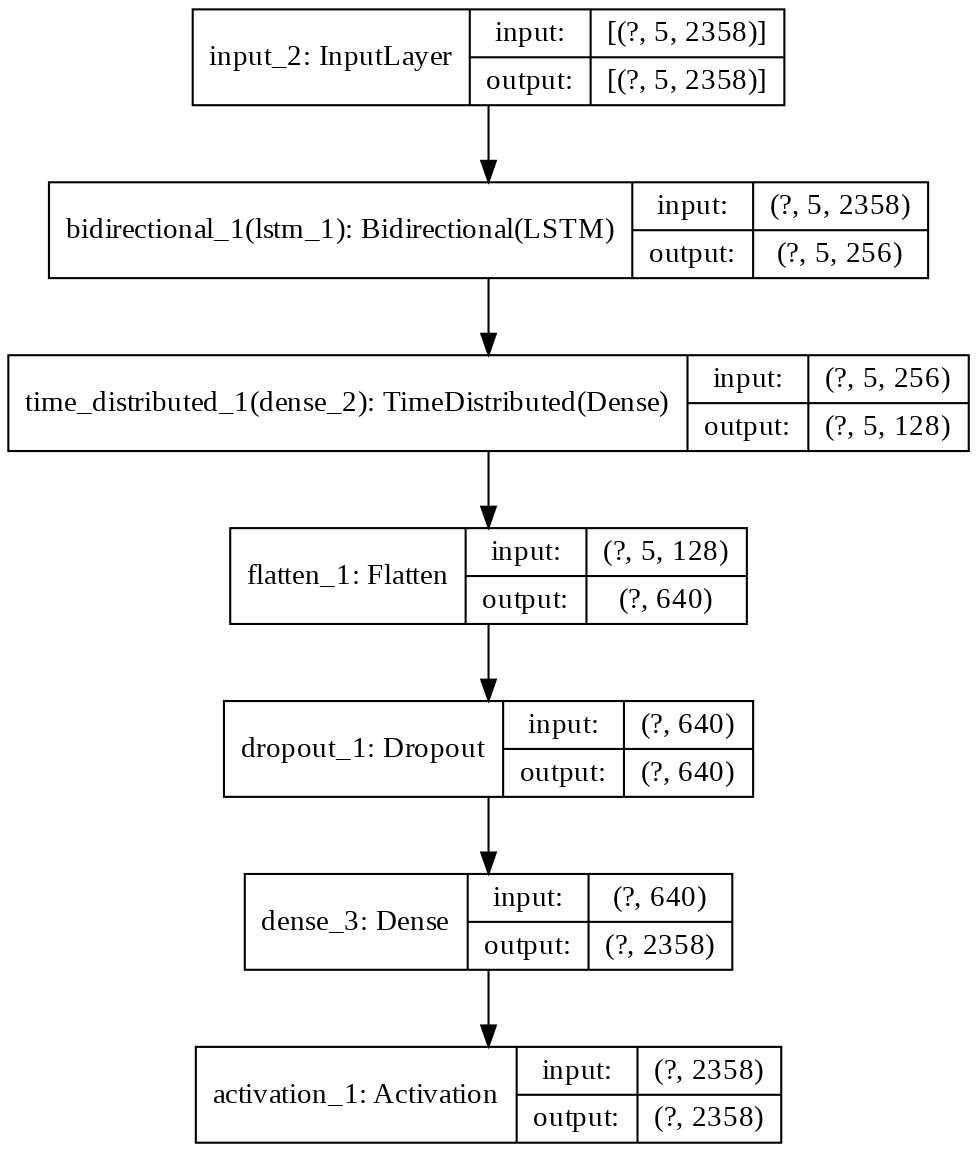

In [ ]:
#####################################################################################################
###################################### BILSTM MODEL FOR LMOTE #######################################
#####################################################################################################

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM, Dense,Bidirectional, Dropout,TimeDistributed,Activation,Flatten
from tensorflow.keras.optimizers import Adam

# NUM_WORDS*N_GRAMS = 11790
# NUM_WORDS =  2358

INPUT_SHAPE = (N_GRAMS,NUM_WORDS)
LEARNING_RATE =0.001    
optimizer = Adam(lr=LEARNING_RATE)

def BILSTM():

    model = Sequential()
    model.add(Input(shape=INPUT_SHAPE))
    model.add(Bidirectional(LSTM(128, activation="relu",return_sequences=True)))  # num para = 2*lstm
    model.add(TimeDistributed(Dense(128, activation='relu'))) # needs 3d>= input
    model.add(Flatten())
    # model.add(Dense(128))
    model.add(Dropout(0.1))
    model.add(Dense(NUM_WORDS))
    model.add(Activation('softmax'))

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=['acc'] # acc means keras will automatically decide which acc to use depending upon input/output shape
    )

    return model

bilstm_model = BILSTM()
bilstm_model.summary()
plot_model(bilstm_model, show_shapes=True, show_layer_names=True, dpi=150, to_file='BILSTM_SEQUENCEGENERATION.png')
Image(retina=True, filename='BILSTM_SEQUENCEGENERATION.png')

In [ ]:
BATCH_SIZE =  50
EPOCHS = 25
history = bilstm_model.fit(
    train_x,
    train_y,
    validation_split=0.1, 
    shuffle=True, 
    epochs=EPOCHS,    
    batch_size=BATCH_SIZE
)

Epoch 1/25
406/406 [==============================] - 9s 23ms/step - loss: 6.2471 - acc: 0.0899 - val_loss: 6.0589 - val_acc: 0.0843
Epoch 2/25
406/406 [==============================] - 9s 22ms/step - loss: 5.9543 - acc: 0.0910 - val_loss: 6.0645 - val_acc: 0.0843
Epoch 3/25
406/406 [==============================] - 9s 22ms/step - loss: 5.8825 - acc: 0.0947 - val_loss: 6.0329 - val_acc: 0.0918
Epoch 4/25
406/406 [==============================] - 9s 22ms/step - loss: 5.7273 - acc: 0.1099 - val_loss: 5.9492 - val_acc: 0.1038
Epoch 5/25
406/406 [==============================] - 9s 22ms/step - loss: 5.4776 - acc: 0.1248 - val_loss: 5.8861 - val_acc: 0.1100
Epoch 6/25
406/406 [==============================] - 9s 23ms/step - loss: 5.1437 - acc: 0.1435 - val_loss: 5.8256 - val_acc: 0.1189
Epoch 7/25
406/406 [==============================] - 9s 22ms/step - loss: 4.7521 - acc: 0.1673 - val_loss: 5.9125 - val_acc: 0.1198
Epoch 8/25
406/406 [==============================] - 9s 23ms/step - 

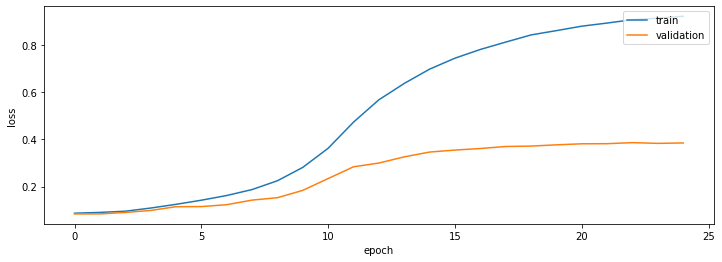

In [ ]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
# SAVE/LOAD MODEL
bilstm_model.save('/content/drive/My Drive/tempData/MJ-BILSTM-LMOTE.h5')

In [ ]:
bilstm_model.load_weights('/content/drive/My Drive/tempData/MJ-BILSTM-LMOTE.h5')

In [ ]:
# TEST PREDICTIONS FROM SEED SEQUENCES
MAX_SEQ_LEN = 150

END_VEC= np.zeros((1,NUM_WORDS))
END_VEC[0][word_to_int[END]]=1

def predict(input_seq):

  words = input_seq.split(' ')
  itr = len(words)

  # check if is valid
  for w in words:
    if w not in unique_words:
      print(w+' Not Found in Dict')
      returnimport numpy as np
      
  input_seq = list(np.zeros((5,NUM_WORDS)))
  for i in range(min(5,itr)):
    input_seq[4-i][word_to_int[words[itr-1-i]]]=1

  while itr<MAX_SEQ_LEN:
    itr=itr+1
    next_word = bilstm_model.predict(np.array([input_seq]))
    at = np.argmax(next_word[0])
    # print(len(input_seq),'-x',len(input_seq[0]),int_to_word[at],len(next_word),len(next_word[0]))
    # print(int_to_word[at])

    if at==1:
      # print('got end!')
      break

    words.append(int_to_word[at])
    wordVec= np.zeros(NUM_WORDS)
    wordVec[at]=1
    input_seq.append(wordVec)
    input_seq= input_seq[1:]

  # return after removing the separaters
  if words[0]=='BEG': 
    return ' '.join(words[1:])
  return ' '.join(words)

predict('BEG you should consider remove')

'you should consider remove from from code'

In [ ]:
predict('can you build web application')

'can you build web application can have that see all since install these would add the ability write the camera'

In [ ]:
imbalance_count = len(non_sugg)-len(sugg)
print(imbalance_count)

4330


In [ ]:
# TOP N-GRAMS FROM THE SUGGESTIONS TRAINING DATA
count =  {}
for ngram in ngrams['ngrams']:
  if ngram in count:
    count[ngram]=count[ngram]+1
  else:
    count[ngram]=1
ordered = sorted(count.items(), key=lambda kv: -kv[1])

print(ordered)

top_ngrams = []
significant_ngrams = 0
for i in range(2000):
  if ordered[i][1]==1:
    break
  significant_ngrams=significant_ngrams+1
  top_ngrams.append(ordered[i][0])

# TOO LESS NUMBER OF DISTINCT NGRAMS
print(top_ngrams)
print(significant_ngrams)

[('BEG should option remove the', 4), ('should option remove the language', 4), ('option remove the language code', 4), ('remove the language code from', 4), ('the language code from language', 4), ('language code from language history', 4), ('trial feature should built with', 4), ('BEG would like the ability', 4), ('BEG would like see the', 4), ('BEG would great there be', 4), ('please enable remove language code', 3), ('enable remove language code from', 3), ('remove language code from the', 3), ('language code from the dev', 3), ('code from the dev center', 3), ('from the dev center language', 3), ('the dev center language history', 3), ('then cause tile localization show', 3), ('cause tile localization show the', 3), ('tile localization show the default', 3), ('localization show the default tile', 3), ('show the default tile localization', 3), ('BEG would extremely helpful the', 3), ('BEG please add support for', 3), ('BEG would expect the store', 3), ('would expect the store capab

In [ ]:
# TOP N-GRAMS FROM THE THE NON SUGGESTION TEXTS
ns_ngrams =  pd.DataFrame(columns = ['ngrams'])
id=0
for text in non_sugg:
  words = text.split(' ')
  for i in range(len(words)-N_GRAMS):
    # ns_ngrams[id] will make a new column with header name id
    ns_ngrams.loc[id]=[' '.join(words[i:i+N_GRAMS])]
    id=id+1
print(id)
ns_ngrams.head()

56484


ngrams
0    BEG note your file there
1  note your file there entry
2  your file there entry like
3  file there entry like this
4  there entry like this when

In [ ]:
# FIND TOP N-GRAMS FROM THE SUGGESTIONS 
count =  {}
for ngram in ngrams['ngrams']:
  if ngram in count:
    count[ngram]=count[ngram]+1
  else:
    count[ngram]=1

# FIND TOP N-GRAMS FROM THE SUGGESTIONS 
for ngram in ns_ngrams['ngrams']:
  if ngram in count:
    count[ngram]=count[ngram]+1
  else:
    count[ngram]=1

ordered = sorted(count.items(), key=lambda kv: -kv[1])
print(ordered)

# COUNT UNIQUE NGRAMS FOUND 
significant_ngrams = 0
while ordered[significant_ngrams][1] > 1:
  significant_ngrams=significant_ngrams+1
print(significant_ngrams)

[('with the same file extension', 9), ('format with the same file', 6), ('this with the window phone', 5), ('with the window phone world', 5), ('the window phone world where', 5), ('because the restriction window phone', 5), ('not fully replace the old', 5), ('fully replace the old version', 5), ('BEG buffer overrun while write', 5), ('buffer overrun while write the', 5), ('overrun while write the writable', 5), ('while write the writable size', 5), ('write the writable size but', 5), ('the writable size but might', 5), ('writable size but might write', 5), ('then cause tile localization show', 4), ('cause tile localization show the', 4), ('tile localization show the default', 4), ('localization show the default tile', 4), ('show the default tile localization', 4), ('BEG should option remove the', 4), ('should option remove the language', 4), ('option remove the language code', 4), ('remove the language code from', 4), ('the language code from language', 4), ('language code from langua

In [ ]:
# SELECT THE TOP REQUEIRDE NGRAMS  
top_ngrams = []
skipped = 0 

for i in range(len(ordered)):
  valid = True
  for word in ordered[i][0].split(' '):
    # if this sentence is invalid (contatins words not in sugg text dictionary)
    if word not in unique_words:
      valid = False
      break
  if valid == True:
    top_ngrams.append(ordered[i][0])
    if len(top_ngrams)==imbalance_count:
      print('Compeleted at',i+1,'th text')
      break
  else:
    skipped = skipped+1

print(len(top_ngrams),top_ngrams)

Compeleted at 4789 th text
4330 ['with the same file extension', 'format with the same file', 'this with the window phone', 'with the window phone world', 'the window phone world where', 'because the restriction window phone', 'not fully replace the old', 'fully replace the old version', 'then cause tile localization show', 'cause tile localization show the', 'tile localization show the default', 'localization show the default tile', 'show the default tile localization', 'BEG should option remove the', 'should option remove the language', 'option remove the language code', 'remove the language code from', 'the language code from language', 'language code from language history', 'trial feature should built with', 'BEG would like the ability', 'the resize photo from the', 'BEG would like see the', 'BEG would great there be', 'track the number day since', 'the number day since install', 'number day since install whether', 'day since install whether the', 'since install whether the user', 

In [ ]:
ngrams_pred=[]
for i in range(len(top_ngrams)):
  ngrams_pred.append(predict(top_ngrams[i]))
  if i%50 == 0:
    print('Generated ',i+1,' sentences!')
    
comp = pd.DataFrame(columns=['input','prediction'])
for i in range(len(top_ngrams)):
  comp.loc[i]=[top_ngrams[i],ngrams_pred[i]] 
comp.head(50)

input                                                                                                                                                                                                      prediction
0           with the same file extension  with the same file extension and memory support use for all user and submit file with the and allow the paper only for example constant for every title and control limited for the store for the tile preview
1              format with the same file                                        format with the same file the phone memory but maybe work will expand use the like whether the package for network load from the user can have appointment the the store
2             this with the window phone                                                                                                                         this with the window phone world where tell you want trial mode but have track the file
3            with the window phone world                                                                                                                              with the window phone world where tell you want trial mode but have track the file
4           the window phone world where                                                                                                                                   the window phone world where tell you want trial mode but have track the file
5   because the restriction window phone                                                                                                                 because the restriction window phone and also show the ability the file and the the lock screen
6              not fully replace the old                                                                                                                                                                               not fully replace the old service
7          fully replace the old version                                                                                                                                                                                   fully replace the old version
8      then cause tile localization show                                                                                                                                       then cause tile localization show the default tile localization which bad
9       cause tile localization show the                                                                                                                                            cause tile localization show the default tile localization which bad
10    tile localization show the default                                                                                                                                                  tile localization show the default tile localization which bad
11    localization show the default tile                                                                                                                                                       localization show the default tile localization which bad
12    show the default tile localization                                                                                                                                                                    show the default tile localization which bad
13          BEG should option remove the                                                                                                                   should option remove the language code from language history option replace fully replace the
14     should option remove the language                                                                                                                   should option remove the language code from language history option replace fully replace the
15       option remove the language code           

In [ ]:
train_data.tail(10)

id  ...                                                                                                                                           cleaned
8490  2824  ...                                          example best example the have this control where suggest video from different channel be show single row
8491  2831  ...                                                        scroll navigation button right side next button left side the control will previous button
8492  2832  ...              next previous behaviour the available screen will show the number item the row the control accord size the control and size the item
8493  2836  ...                                                                                have not found any possible way that assume do not exist currently
8494  2838  ...                                                                    the implementation appear very unstable general but doubly when compile native
8495  2839  ...                                                                                              the follow will reliably throw some flavor exception
8496  2840  ...                                                                           this will reliably result zero be return not clear why not block either
8497  2842  ...                                                                            now only possible set the property tell the control which calender use
8498  2843  ...           not possible set the adjustment for the month though which can vary per region user some user like use the adjustment different country
8499  2844  ...  the window calender show case this feature with their calender when you set the alternative calender new set show which adjustment and work nice

[10 rows x 4 columns]

In [ ]:
id = len(train_data)
for text in ngrams_pred:
  train_data.loc[id]=[str(id),text,1,text]   # id uncleaned label cleaned
  id=id+1
train_data.tail(50)

id  ...                                                                                                                                                                                                                         cleaned
12780  12780  ...                                                                                                                                                                                            be able modify non calendar provider
12781  12781  ...                                                                                                                                                                                              able modify non calendar until day
12782  12782  ...                                                                                                                                                                                                  modify non calendar until save
12783  12783  ...                                                                                                                                                 when look help example the list use the native button have their feed pull into
12784  12784  ...                                                                                                                                                                                       when look help example while the item use
12785  12785  ...                                                                                                                                                                                                    look help example while work
12786  12786  ...                                                                                                                                                                                               help example while work code path
12787  12787  ...                                                                                                                                                                                               example while work code sometimes
12788  12788  ...                                                                                                                                                                                                   while work code sometimes run
12789  12789  ...                                                                                                                                                                            work code sometimes run into the universal not embed
12790  12790  ...                                                                                                                                                                                              code sometimes run into difference
12791  12791  ...                                                                                          sometimes run into difference between android and window phone much these may not matter but for the time be these would nice addition
12792  12792  ...                                                                                                                                      run into difference between window phone and device much these need like the functionality
12793  12793  ...                                                                                                                    into difference between window and phone device much these may need define the panel for use the certificate
12794  12794  ...                                                                                                                                                                                 difference between window and but even the game
12795  12795  ...                                                                                                                   betwee

In [ ]:
print(len(train_data),len(sugg)+len(non_sugg)+imbalance_count)

12830 12830


In [ ]:
# SHUFFLE AND SAVE
from sklearn.utils import shuffle
train_data = shuffle(train_data)
train_data.head(50)
pickle.dump(train_data,open('/content/drive/My Drive/tempData/train_clean_lmote.data','wb'))

id  ...                                                                                                                                                                                                                                                                                                      cleaned
7529      1352  ...                                                                                                                                                                                       this issue be report for visual studio feedback site but they have determine that this issue universal window platform
7366       960  ...                                                                                                                                                                                              not offer tool and only part the window driver kit must the entire window driver kit access this one small tool
6133      2968  ...                                                                                                                                                                                                                                                                     these be widely use the real world today
8992      8992  ...                                                                                                                                                                                                                                                        enforcement user prompt disable just the window store
1974    1719_2  ...                                                                                                                                                                                                                                        this property should return correct information about connect headset
5032      1870  ...                                                                                                                                                                                                                                                     please add order allow calendar remote calendar provider
9625      9625  ...                                                                                                                                                                                                        they fall short when deal with more complex data this should work just like any other kind image data
5891      2224  ...                                                                                                                                                                                                                                would fit the purpose except require embed mode and therefore cannot use this
11709    11709  ...                                                                                                                                                                                                                                                                           have take one language change from
9389      9389  ...                                                                                                                                                                                                                                                                               like write the storage similar
3095     0_665  ...                                                               when corporate customer try submit error message your account do not have permission submit the store display and they cannot submit any know that this message mean when vet trigger but this message vague and do not mention what user need
11870    11870  ...                                                                                                                                             